# EDA

In [51]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

## Informasi Dataset

In [52]:
df = pd.read_csv("final_dataset.csv")

df.head()

,Text,Label
0,perpanjang stnk kendaraan,Needs
1,beli air darurat,Needs
2,beli beras merah,Needs
3,beli deterjen pakaian,Needs
4,beli map dokumen,Needs


In [53]:
df.shape

(10000, 2)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    10000 non-null  object
 1   Label   10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


## Pengecekan Duplikat

In [55]:
df.duplicated().sum()

np.int64(2987)

In [56]:
df['Text'].duplicated().sum()

np.int64(2987)

In [57]:
df[df['Text'].duplicated(keep=False)].sort_values('Text')

,Text,Label
6401,akumulasi dana aman,Savings
6773,akumulasi dana aman,Savings
6560,akumulasi dana aman,Savings
6379,akumulasi dana perlahan,Savings
6597,akumulasi dana perlahan,Savings
...,...,...
3041,upgrade setup gaming,Wants
2897,upgrade setup gaming,Wants
8924,yield farming crypto,Invest
8999,yield farming crypto,Invest


In [58]:
df = df.drop_duplicates(subset='Text', keep='first')

In [59]:
df.duplicated().sum()

np.int64(0)

In [60]:
df.isnull().sum()

Text     0
Label    0
dtype: int64

## Persebaran Data

In [61]:
df['Label'].value_counts()

Label
Needs      1412
Invest     1411
Wants      1402
Savings    1395
Debts      1393
Name: count, dtype: int64

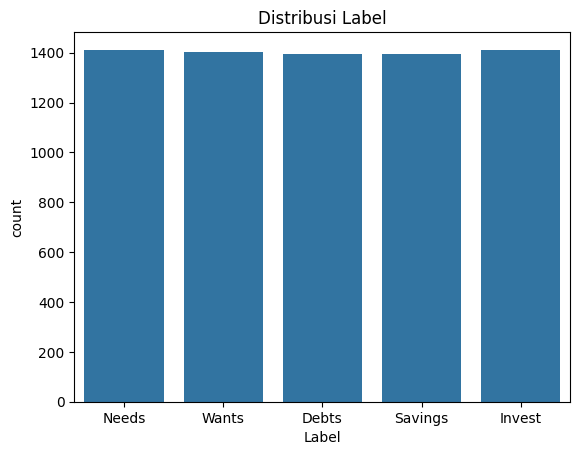

In [62]:
plt.figure()
sns.countplot(x='Label', data=df)
plt.title("Distribusi Label")
plt.show()

In [63]:
df['text_length'] = df['Text'].astype(str).apply(len)

df['text_length'].describe()

count    7013.000000
mean       34.692001
std        17.452456
min         7.000000
25%        21.000000
50%        29.000000
75%        48.000000
max        81.000000
Name: text_length, dtype: float64

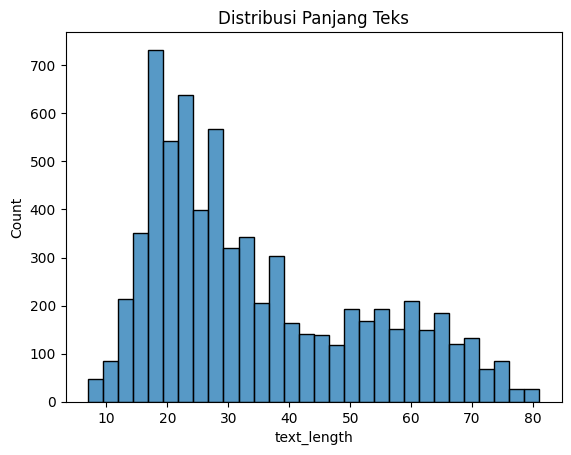

In [64]:
plt.figure()
sns.histplot(df['text_length'], bins=30)
plt.title("Distribusi Panjang Teks")
plt.show()

In [65]:
df.groupby('Label')['text_length'].mean()

Label
Debts      36.251256
Invest     37.372785
Needs      30.197592
Savings    39.729032
Wants      29.959344
Name: text_length, dtype: float64

In [66]:
df.shape

(7013, 3)

# Preprocessing

In [67]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Label'])

df[['Label','label_encoded']].head()

,Label,label_encoded
0,Needs,2
1,Needs,2
2,Needs,2
3,Needs,2
4,Needs,2


## Save to CSV

In [68]:
df.to_csv("final_dataset_clean.csv", index=False)

# Train Model Indobert

In [ ]:
import joblib # Import library 
joblib.dump(le, "label_encoder.pkl") # simpan objek le ke file label_encoder.pkl

['label_encoder.pkl']

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].tolist(), # ambil kolom text ubah ke list
    df["label_encoded"].tolist(), # ambil label yang udah di encode jadi list
    test_size=0.3, # 30% data buat validation
    stratify=df["label_encoded"], # agar proporsi label di train dan val sama
    random_state=42 # hasil split konsisten setiap run
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "indobenchmark/indobert-base-p1" # fungsinya untuk load tokenizer dari model
)

In [ ]:
train_encodings = tokenizer(
    train_texts, # kumpulan teks untuk training
    truncation=True, # kalau text terlalu panjang maka akan di potong
    padding=True, # kalau kependek maka akan di tambahkan padding
    max_length=64 # maksimal panjang teks yang di proses
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=64
)

In [ ]:
class BudgetDataset(torch.utils.data.Dataset): # bikin custom dataset biar bisa di pyTorch
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels # buat nyimpan hasil tokenizer + label ke dalam class

    def __len__(self):
        return len(self.labels) # buat ngasih tau panjang dataset berdasarkan jumlah label

    def __getitem__(self, idx): # buat ngambil item berdasarkan index
        # buat ngambil item dari hasil tokenizer berdasarkan index dan ubah ke tensor
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        # buat ngambil label berdasarkan index dan ubah ke tensor
        item["labels"] = torch.tensor(self.labels[idx])
        # balikin 1 data yang udah di proses untuk siap masuk ke model
        return item

In [ ]:
# bikin object dataset untuk training dan validation dengan masukin hasil 
# tokenizer dan label yang udah di encodem isinya input_ids, attention_mask, dan label yang udah di encode
train_dataset = BudgetDataset(train_encodings, train_labels)
val_dataset = BudgetDataset(val_encodings, val_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained( # load indobert untuk versi yang udah layer klasifikasi
    "indobenchmark/indobert-base-p1", # base model yang dipake untuk klasifikasi
    num_labels=len(le.classes_) # jumlah output harus sesuai dengan jumlah kelas yang mau di prediksi
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./indobert-dataset", # simpan hasil training di folder ini
    eval_strategy="epoch", # evaluasi dilakukan setiap akhir epoch
    save_strategy="epoch", # simpan model setiap akhir epoch
    learning_rate=2e-5, # kecepatan belajar atau kecepatan update weights model
    per_device_train_batch_size=16, # jumlah data yang diproses dalam 1 batch saat training
    per_device_eval_batch_size=16, # jumlah data yang diproses dalam 1 batch saat evaluasi
    num_train_epochs=4, # Train diulang sebanyak 4 kali untuk semua data
    weight_decay=0.01, # Regulasi untuk mencegah overfitting
    logging_steps=50, # buat ngasih tau setiap 50 langkah training akan ada log yang muncul
    load_best_model_at_end=True, # setelah training selesai, otomatis ambil yang terbaik
    # buat ngasih tau kalau model terbaik itu yang punya eval_loss paling kecil
    metric_for_best_model="eval_loss"
)   

In [ ]:
trainer = Trainer(
    model=model, # model yang dipake
    args=training_args, # setingan training yang udah di buat
    train_dataset=train_dataset, # data train
    eval_dataset=val_dataset, # data testing
    tokenizer=tokenizer
)

C:\Users\dwiok\AppData\Local\Temp\ipykernel_6172\3286434519.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train() # start training model dengan settingan yang udah di buat

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.040400,0.034674
2,0.008400,0.022925
3,0.005300,0.020893
4,0.000500,0.025007


C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1228, training_loss=0.04541641978489338, metrics={'train_runtime': 2419.9159, 'train_samples_per_second': 8.114, 'train_steps_per_second': 0.507, 'total_flos': 151364878283880.0, 'train_loss': 0.04541641978489338, 'epoch': 4.0})

In [ ]:
trainer.save_model("./indobert-dataset-final") # simpan hasil training model ke folder ini
tokenizer.save_pretrained("./indobert-dataset-final") # simpan tokenize ke folder yang sama

('./indobert-dataset-final\\tokenizer_config.json',
 './indobert-dataset-final\\special_tokens_map.json',
 './indobert-dataset-final\\vocab.txt',
 './indobert-dataset-final\\added_tokens.json',
 './indobert-dataset-final\\tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib # buat load label encoder 
import torch # buat tensor dan inference

# load tokenizer hasil training yang udah di simpan
tokenizer = AutoTokenizer.from_pretrained("./indobert-dataset-final")
# load model indobert yang udah di training
model = AutoModelForSequenceClassification.from_pretrained(
    "./indobert-dataset-final"
)
# buat masukin model ke mode evaluasi biar gak ada 
# dropout dan lain lain yang bikin hasil gak konsisten
model.eval() 

# load label encoder yang udah di simpan
le = joblib.load("label_encoder.pkl")

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def predict_base(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )

    with torch.no_grad(): # fungsinya untuk mematikan gradient karena kita cuma mau prediksi
        outputs = model(**inputs) # masukin input ke model untuk dapetin outputnya
        probs = torch.softmax(outputs.logits, dim=1) # ubah logits jadi probabilitas dengan softmax
        pred_id = torch.argmax(probs).item() # ambil index dari kelas dengan probabilitas tertinggi
        confidence = probs.max().item() # ambil nilai probabilitas tertinggi sebagai confidence
    # ubah angka kelas jadi label asli
    label = le.inverse_transform([pred_id])[0]
    # kembalikan label, confidence, dan text asli untuk ditampilkan
    return label, confidence, text


In [50]:
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(val_labels, y_pred, target_names=le.classes_))

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       Debts       1.00      1.00      1.00       418
      Invest       1.00      1.00      1.00       423
       Needs       0.99      0.99      0.99       424
     Savings       1.00      1.00      1.00       418
       Wants       0.99      1.00      0.99       421

    accuracy                           1.00      2104
   macro avg       1.00      1.00      1.00      2104
weighted avg       1.00      1.00      1.00      2104



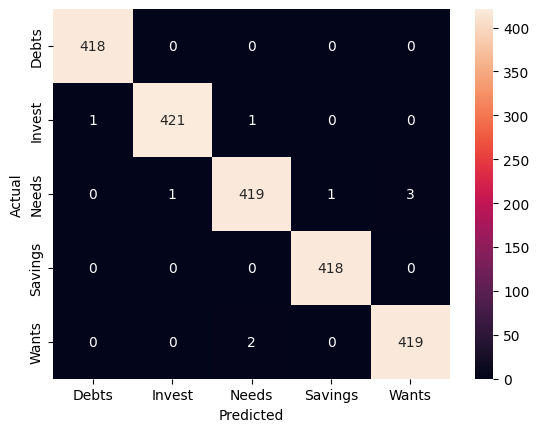

In [51]:
cm = confusion_matrix(val_labels, y_pred)   

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
predict_base("beli saham") # contoh input untuk prediksi

('Invest', 0.999546468257904, 'beli saham')

# Train Model Mbert

In [54]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].tolist(),
    df["label_encoded"].tolist(),
    test_size=0.3,
    stratify=df["label_encoded"],
    random_state=42
)

In [55]:
tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-multilingual-cased"
)

In [56]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=64
)

In [57]:
class BudgetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [58]:
train_dataset = BudgetDataset(train_encodings, train_labels)
val_dataset = BudgetDataset(val_encodings, val_labels)

In [59]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(le.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
training_args = TrainingArguments(
    output_dir="./mbert-dataset",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)   

In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

C:\Users\dwiok\AppData\Local\Temp\ipykernel_6172\3286434519.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [62]:
trainer.train()

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.105100,0.099523
2,0.022800,0.055327
3,0.020000,0.049221
4,0.017400,0.042838


C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1228, training_loss=0.1225993723611587, metrics={'train_runtime': 4065.0768, 'train_samples_per_second': 4.83, 'train_steps_per_second': 0.302, 'total_flos': 252274797139800.0, 'train_loss': 0.1225993723611587, 'epoch': 4.0})

In [63]:
trainer.save_model("./mbert-dataset-final")
tokenizer.save_pretrained("./mbert-dataset-final")

('./mbert-dataset-final\\tokenizer_config.json',
 './mbert-dataset-final\\special_tokens_map.json',
 './mbert-dataset-final\\vocab.txt',
 './mbert-dataset-final\\added_tokens.json',
 './mbert-dataset-final\\tokenizer.json')

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib
import torch

tokenizer = AutoTokenizer.from_pretrained("./mbert-dataset-final")
model = AutoModelForSequenceClassification.from_pretrained(
    "./mbert-dataset-final"
)
model.eval()

le = joblib.load("label_encoder.pkl")

The tokenizer you are loading from './mbert-dataset-final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [20]:
def predict_base_mbert(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_id = torch.argmax(probs).item()
        confidence = probs.max().item()

    label = le.inverse_transform([pred_id])[0]
    return label, confidence, text


In [66]:
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(val_labels, y_pred, target_names=le.classes_))

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       Debts       1.00      1.00      1.00       418
      Invest       1.00      0.99      1.00       423
       Needs       0.98      0.99      0.99       424
     Savings       1.00      1.00      1.00       418
       Wants       0.99      0.99      0.99       421

    accuracy                           0.99      2104
   macro avg       0.99      0.99      0.99      2104
weighted avg       0.99      0.99      0.99      2104



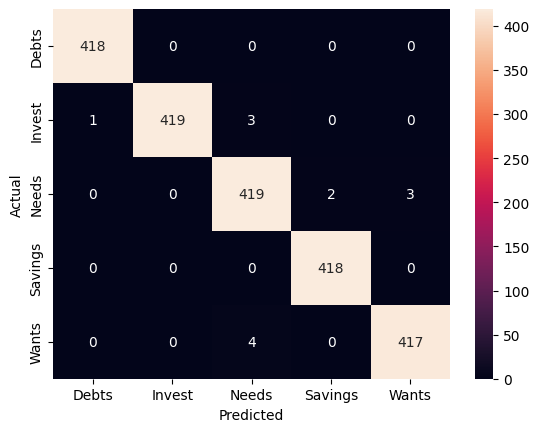

In [67]:
cm = confusion_matrix(val_labels, y_pred)   

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
predict_base_mbert("nimpen duit buay libran")

('Needs', 0.9986296892166138, 'nimpen duit buay libran')

# Train model Linear SVM

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Text"].tolist(), df["label_encoded"].tolist(), test_size=0.3, random_state=42, stratify=df["label_encoded"].tolist()
)
print('Train size:', len(X_train))
print('Test size :', len(X_test))


Train size: 4909
Test size : 2104


In [46]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import joblib

In [70]:
base_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ('svm', LinearSVC(class_weight='balanced', random_state=42))
])

svm_clf = CalibratedClassifierCV(estimator=base_svm, method='sigmoid', cv=3)
svm_clf


,estimator,Pipeline(step...m_state=42))])
,method,'sigmoid'
,cv,3
,n_jobs,None
,ensemble,'auto'
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None


In [71]:
svm_clf.fit(X_train, y_train)
print('Training done.')

Training done.


In [72]:
y_pred = svm_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)

print(f'Accuracy          : {acc:.4f}')
print(f'Balanced Accuracy : {bacc:.4f}')
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, digits=4))

labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
print('Labels:', labels)
print('Confusion matrix shape:', cm.shape)


Accuracy          : 0.9895
Balanced Accuracy : 0.9896

Classification Report:

              precision    recall  f1-score   support

           0     0.9976    1.0000    0.9988       418
           1     1.0000    0.9858    0.9929       423
           2     0.9720    0.9811    0.9765       424
           3     0.9952    1.0000    0.9976       418
           4     0.9833    0.9810    0.9822       421

    accuracy                         0.9895      2104
   macro avg     0.9896    0.9896    0.9896      2104
weighted avg     0.9896    0.9895    0.9896      2104

Labels: [0 1 2 3 4]
Confusion matrix shape: (5, 5)


In [75]:
def prediksi_budget_dengan_confidence(text: str):
    probs = svm_clf.predict_proba([text])[0]
    classes = svm_clf.classes_
    pred_idx = int(np.argmax(probs))
    return classes[pred_idx], float(probs[pred_idx])

contoh_kalimat = [
    "Membeli perlengkapan untuk mandi",
    "blnja bulan",
    "Makan malam di Mcd",
    "bli tiket konsr blackpink",
    "membayar cicilan mobil",
    "ccilan karut kredit",
    "membeli deposito di bank bca",
    "membangun kontrkana 3 pintur",
    "menambah saldo rekening tabunganku untuk dana darurat",
    "nimpen duit buay libran"
]

label_map = {
    0: "Debts",
    1: "Invest",
    2: "Needs",
    3: "Savings",
    4: "Wants"
}


for kalimat in contoh_kalimat:
    label_idx, conf = prediksi_budget_dengan_confidence(kalimat)
    label = label_map[label_idx]
    print(kalimat)
    print(f'Prediksi  : {label}')
    print(f'Confidence: {conf:.2%}')
    print('-'*35)



Membeli perlengkapan untuk mandi
Prediksi  : Needs
Confidence: 56.32%
-----------------------------------
blnja bulan
Prediksi  : Invest
Confidence: 63.23%
-----------------------------------
Makan malam di Mcd
Prediksi  : Wants
Confidence: 96.06%
-----------------------------------
bli tiket konsr blackpink
Prediksi  : Wants
Confidence: 98.53%
-----------------------------------
membayar cicilan mobil
Prediksi  : Debts
Confidence: 97.59%
-----------------------------------
ccilan karut kredit
Prediksi  : Debts
Confidence: 99.88%
-----------------------------------
membeli deposito di bank bca
Prediksi  : Invest
Confidence: 91.01%
-----------------------------------
membangun kontrkana 3 pintur
Prediksi  : Wants
Confidence: 50.07%
-----------------------------------
menambah saldo rekening tabunganku untuk dana darurat
Prediksi  : Savings
Confidence: 99.64%
-----------------------------------
nimpen duit buay libran
Prediksi  : Wants
Confidence: 50.07%
---------------------------------

# Train model Decision Tree

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['Text'])
y = df['label_encoded']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth=15)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [82]:
y_pred = clf.predict(X_test)
print(f"Akurasi Model: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nDetail Laporan:")
print(classification_report(y_test, y_pred, target_names=df["Label"].unique()))

Akurasi Model: 72.43%

Detail Laporan:
              precision    recall  f1-score   support

       Needs       0.99      0.89      0.94       393
       Wants       0.97      0.64      0.77       434
       Debts       0.88      0.26      0.40       445
     Savings       1.00      0.88      0.94       405
      Invest       0.44      1.00      0.61       427

    accuracy                           0.72      2104
   macro avg       0.85      0.73      0.73      2104
weighted avg       0.85      0.72      0.72      2104



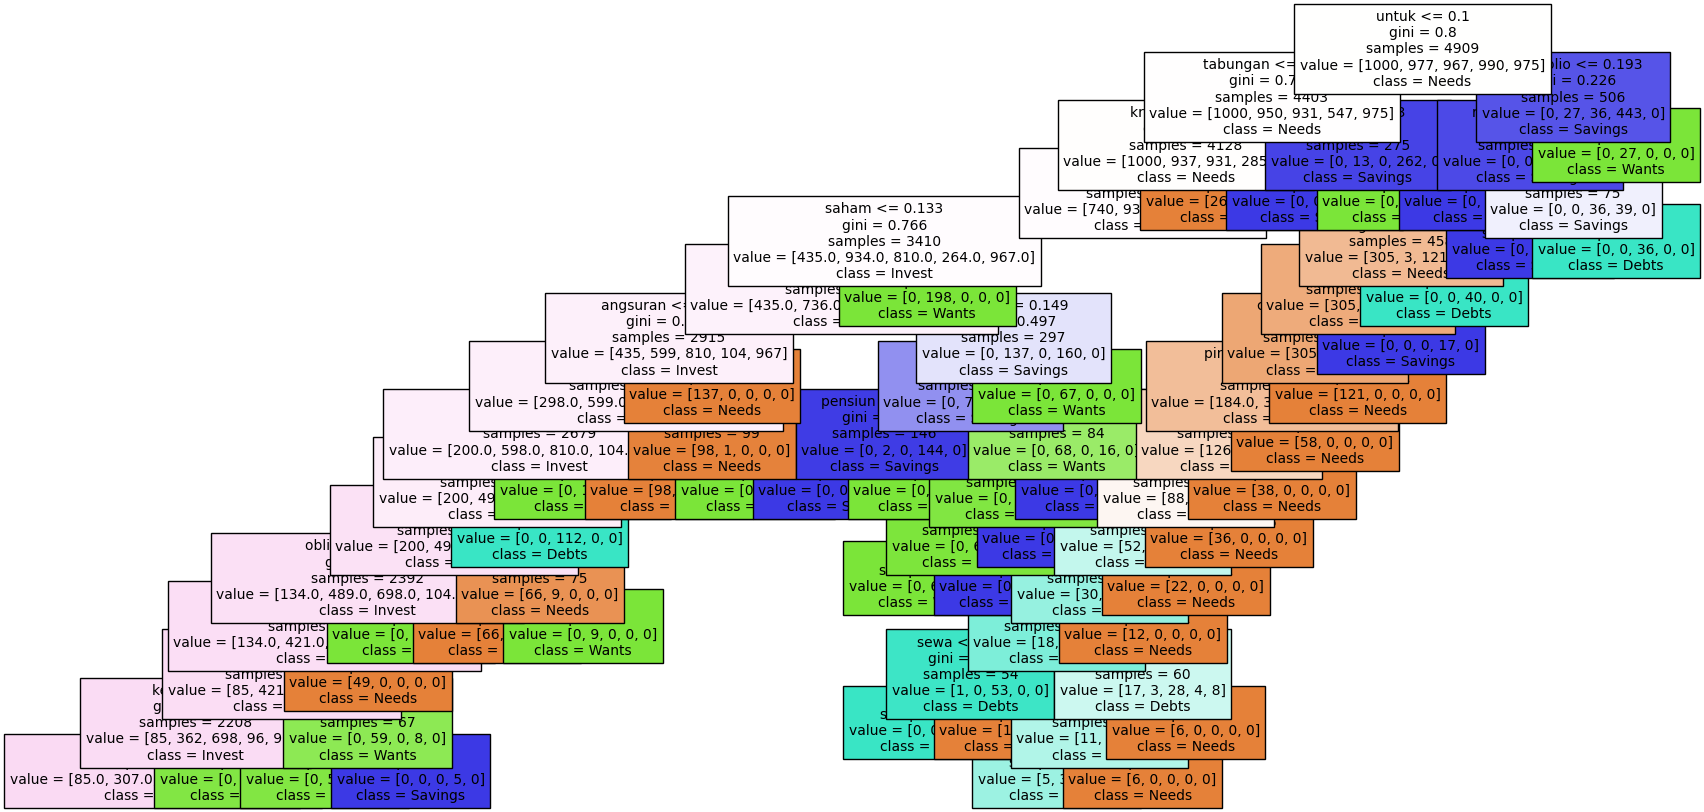

In [83]:
plt.figure(figsize=(20, 10))
plot_tree(clf,
          feature_names=tfidf.get_feature_names_out(),
          class_names=df["Label"].unique(),
          filled=True,
          fontsize=10)
plt.savefig('decision_tree_result.png')
plt.show()

# Train model XLM Roberta

In [19]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].tolist(),
    df["label_encoded"].tolist(),
    test_size=0.3,
    stratify=df["label_encoded"],
    random_state=42
)

In [20]:
tokenizer = AutoTokenizer.from_pretrained(
    "xlm-roberta-base"
)

In [21]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=64
)

In [22]:
class BudgetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [23]:
train_dataset = BudgetDataset(train_encodings, train_labels)
val_dataset = BudgetDataset(val_encodings, val_labels)

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(le.classes_)
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
training_args = TrainingArguments(
    output_dir="./XLM-dataset",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)   

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

C:\Users\dwiok\AppData\Local\Temp\ipykernel_5088\3286434519.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
trainer.train()

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.155300,0.065798
2,0.047700,0.080329
3,0.031100,0.060536
4,0.053200,0.050536


C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1228, training_loss=0.1819916766755744, metrics={'train_runtime': 3191.8318, 'train_samples_per_second': 6.152, 'train_steps_per_second': 0.385, 'total_flos': 171546862055064.0, 'train_loss': 0.1819916766755744, 'epoch': 4.0})

In [28]:
trainer.save_model("./XLM-dataset-final")
tokenizer.save_pretrained("./XLM-dataset-final")

('./XLM-dataset-final\\tokenizer_config.json',
 './XLM-dataset-final\\special_tokens_map.json',
 './XLM-dataset-final\\tokenizer.json')

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib
import torch

tokenizer = AutoTokenizer.from_pretrained("./XLM-dataset-final")
model = AutoModelForSequenceClassification.from_pretrained(
    "./XLM-dataset-final"
)
model.eval()

le = joblib.load("label_encoder.pkl")

The tokenizer you are loading from './XLM-dataset-final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [34]:
def predict_base_XLM(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_id = torch.argmax(probs).item()
        confidence = probs.max().item()

    label = le.inverse_transform([pred_id])[0]
    return label, confidence, text


In [31]:
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(val_labels, y_pred, target_names=le.classes_))

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       Debts       0.99      1.00      1.00       418
      Invest       1.00      0.99      0.99       423
       Needs       0.96      0.99      0.98       424
     Savings       1.00      1.00      1.00       418
       Wants       1.00      0.97      0.98       421

    accuracy                           0.99      2104
   macro avg       0.99      0.99      0.99      2104
weighted avg       0.99      0.99      0.99      2104



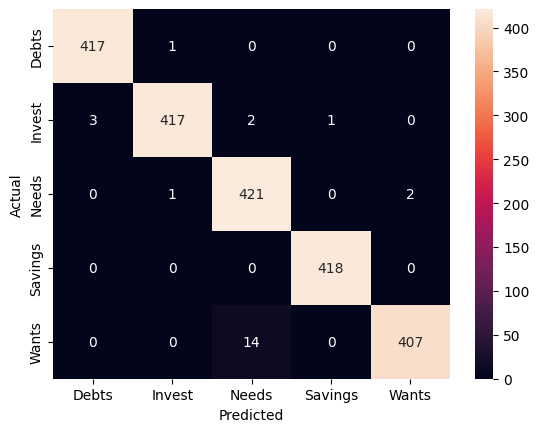

In [32]:
cm = confusion_matrix(val_labels, y_pred)   

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [44]:
predict_base_XLM("nimpen duit buay libran")

('Savings', 0.9993639588356018, 'nimpen duit buay libran')

# Tunning Model Indobert

In [34]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Text"].tolist(),
    df["label_encoded"].tolist(),
    test_size=0.3,
    stratify=df["label_encoded"],
    random_state=42
)

In [35]:
tokenizer = AutoTokenizer.from_pretrained(
    "indobenchmark/indobert-base-p1"
)

In [36]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=64
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=64
)

In [37]:
class BudgetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [38]:
train_dataset = BudgetDataset(train_encodings, train_labels)
val_dataset = BudgetDataset(val_encodings, val_labels)

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=len(le.classes_)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./indobert-dataset-tuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)   

In [41]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

C:\Users\dwiok\AppData\Local\Temp\ipykernel_5088\3286434519.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [42]:
trainer.train()

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.052900,0.029141
2,0.004600,0.029406
3,0.002500,0.021802
4,0.001300,0.021304


C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1228, training_loss=0.06692683633040722, metrics={'train_runtime': 15099.9947, 'train_samples_per_second': 1.3, 'train_steps_per_second': 0.081, 'total_flos': 151364878283880.0, 'train_loss': 0.06692683633040722, 'epoch': 4.0})

In [43]:
trainer.save_model("./indobert-dataset-final-tuned")
tokenizer.save_pretrained("./indobert-dataset-final-tuned")

('./indobert-dataset-final-tuned\\tokenizer_config.json',
 './indobert-dataset-final-tuned\\special_tokens_map.json',
 './indobert-dataset-final-tuned\\vocab.txt',
 './indobert-dataset-final-tuned\\added_tokens.json',
 './indobert-dataset-final-tuned\\tokenizer.json')

In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib
import torch

tokenizer = AutoTokenizer.from_pretrained("./indobert-dataset-final-tuned")
model = AutoModelForSequenceClassification.from_pretrained(
    "./indobert-dataset-final-tuned"
)
model.eval()

le = joblib.load("label_encoder.pkl")

In [77]:
def predict_base_indotuned(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_id = torch.argmax(probs).item()
        confidence = probs.max().item()

    label = le.inverse_transform([pred_id])[0]
    return label, confidence, text


In [46]:
preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(val_labels, y_pred, target_names=le.classes_))

C:\Users\dwiok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       Debts       1.00      1.00      1.00       418
      Invest       1.00      1.00      1.00       423
       Needs       0.99      0.99      0.99       424
     Savings       1.00      1.00      1.00       418
       Wants       0.99      0.99      0.99       421

    accuracy                           1.00      2104
   macro avg       1.00      1.00      1.00      2104
weighted avg       1.00      1.00      1.00      2104



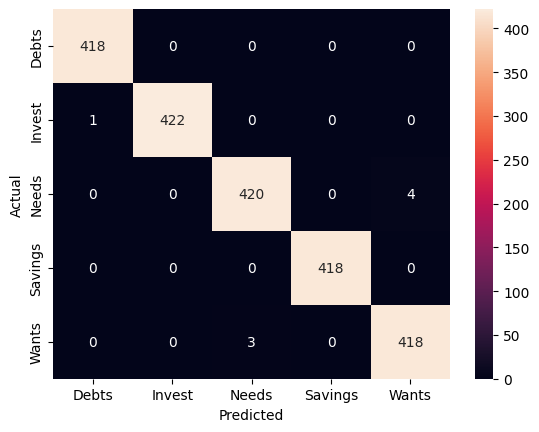

In [47]:
cm = confusion_matrix(val_labels, y_pred)   

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [87]:
predict_base_indotuned("nimpen duit buay libran")

('Savings', 0.8069448471069336, 'nimpen duit buay libran')